In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.optimizers import Adam


In [2]:
# Paths
image_folder =r"C:\_____PYHTON\python\retinopathy_diabetes\gaussian_filtered_images"
csv_path = r"C:\_____PYHTON\python\retinopathy_diabetes\train.csv"


# Step 2.1: Load the CSV file that contains image paths and labels
labels = pd.read_csv(csv_path)

# Step 2.2: Ensure the image paths are valid
labels['image_path'] = labels['image_path'].apply(lambda x: os.path.join(image_folder, x))
labels = labels[labels['image_path'].apply(os.path.exists)]

# Step 2.3: Split the data into training and validation sets
train_df, valid_df = train_test_split(labels, test_size=0.2, random_state=42)

# Step 2.4: Define image size and batch size for training
image_size = (224, 224)
batch_size = 32


KeyError: 'image_path'

In [165]:
# Step 3.1: Define data augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize images
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescaling for validation

# Step 3.2: Ensure labels are treated as strings for categorical classification
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
valid_df['diagnosis'] = valid_df['diagnosis'].astype(str)

# Step 3.3: Create a function to load data from the dataframe using ImageDataGenerator
def load_data(df, image_size, batch_size, datagen):
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='diagnosis',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',  # One-hot encoding for multi-class classification
        shuffle=True
    )

# Step 3.4: Load data for training and validation
train_generator = load_data(train_df, image_size, batch_size, train_datagen)
valid_generator = load_data(valid_df, image_size, batch_size, valid_datagen)


Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [166]:
# Step 4.1: Compute class weights to address class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['diagnosis']),
    y=train_df['diagnosis'].values
)

# Step 4.2: Convert class weights into a dictionary for the fit method
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.4004101161995899, 1: 2.122463768115942, 2: 0.7340852130325815, 3: 4.0680555555555555, 4: 2.3620967741935486}


In [167]:
# Step 5.1: Create the model
num_classes = len(np.unique(train_df['diagnosis']))  # Number of unique classes

# Step 5.2: Initialize the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# Step 5.3: Define the custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Number of output classes
])

# Step 5.4: Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()  # Print model summary


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [168]:
# Inspect the output from the train generator
images, labels = next(train_generator)

print("Images shape:", images.shape)  # Should be (batch_size, 224, 224, 3)
print("Labels shape:", labels.shape)  # Should be (batch_size, num_classes)
print("Labels dtype:", labels.dtype)  # Should be float32


Images shape: (32, 224, 224, 3)
Labels shape: (32, 5)
Labels dtype: float32


In [169]:
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
valid_df['diagnosis'] = valid_df['diagnosis'].astype(str)


In [170]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)


In [171]:
print(train_df.head())  # Ensure columns 'image_path' and 'diagnosis' exist
print(valid_df.head())  # Same for the validation DataFrame


                                             image_path diagnosis  \
2181  C:\_____PYHTON\python\retinopathy_diabetes\gau...         0   
570   C:\_____PYHTON\python\retinopathy_diabetes\gau...         2   
3389  C:\_____PYHTON\python\retinopathy_diabetes\gau...         4   
343   C:\_____PYHTON\python\retinopathy_diabetes\gau...         1   
1801  C:\_____PYHTON\python\retinopathy_diabetes\gau...         0   

                      diagnosis_stage  
2181  No DR (No Diabetic Retinopathy)  
570                          Moderate  
3389                 Proliferative DR  
343                              Mild  
1801  No DR (No Diabetic Retinopathy)  
                                             image_path diagnosis  \
2059  C:\_____PYHTON\python\retinopathy_diabetes\gau...         0   
1105  C:\_____PYHTON\python\retinopathy_diabetes\gau...         2   
818   C:\_____PYHTON\python\retinopathy_diabetes\gau...         2   
1237  C:\_____PYHTON\python\retinopathy_diabetes\gau...         2   


In [172]:
print("Sample labels (one-hot encoded):")
print(labels[:5])  # Check if labels are arrays like [1, 0, 0, 0, 0]


Sample labels (one-hot encoded):
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [173]:
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
valid_df['diagnosis'] = valid_df['diagnosis'].astype(str)


In [174]:
print("Sample pixel values:")
print(images[0, 0, 0])  # Print the first pixel of the first image


Sample pixel values:
[0.49924952 0.5144637  0.5027677 ]


In [175]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)


In [176]:
for batch_images, batch_labels in train_generator:
    print("Batch image shape:", batch_images.shape)
    print("Batch label shape:", batch_labels.shape)
    print("Batch image dtype:", batch_images.dtype)
    print("Batch label dtype:", batch_labels.dtype)
    break


Batch image shape: (32, 224, 224, 3)
Batch label shape: (32, 5)
Batch image dtype: float32
Batch label dtype: float32


In [177]:
print(train_df.isnull().sum())  # Check for missing values
print(valid_df.isnull().sum())

# Verify all file paths are valid
import os
print(all(os.path.exists(path) for path in train_df['image_path']))
print(all(os.path.exists(path) for path in valid_df['image_path']))


image_path         0
diagnosis          0
diagnosis_stage    0
dtype: int64
image_path         0
diagnosis          0
diagnosis_stage    0
dtype: int64
True
True


In [178]:
import os
d=os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Enable detailed TensorFlow logging
print(d)

0


In [179]:
batch_images, batch_labels = next(train_generator)

# Check the shapes
print("Batch image shape:", batch_images.shape)
print("Batch label shape:", batch_labels.shape)

# Perform a single training step
try:
    loss, accuracy = model.train_on_batch(batch_images, batch_labels)
    print(f"Train step successful: Loss = {loss}, Accuracy = {accuracy}")
except Exception as e:
    print(f"Error during train_on_batch: {e}")


Batch image shape: (32, 224, 224, 3)
Batch label shape: (32, 5)
Train step successful: Loss = 2.014983654022217, Accuracy = 0.25


In [180]:
import tensorflow as tf
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")


TensorFlow Version: 2.18.0
Keras Version: 3.6.0


In [182]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1  # Display progress
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6388 - loss: 0.9755 - val_accuracy: 0.6194 - val_loss: 1.0897
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6300 - loss: 0.9739 - val_accuracy: 0.6317 - val_loss: 1.0621
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6377 - loss: 0.9767 - val_accuracy: 0.6248 - val_loss: 1.0863
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.6188 - loss: 1.0058 - val_accuracy: 0.6207 - val_loss: 1.0818
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.6321 - loss: 1.0016 - val_accuracy: 0.6207 - val_loss: 1.1213
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.6211 - loss: 1.0221 - val_accuracy: 0.6207 - val_loss: 1.1264
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6137 - loss: 1.0135 - val_accuracy: 0.6207 - val_loss: 1.1453
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6430 - loss: 0.9992 - val_accuracy: 0.6207 - v

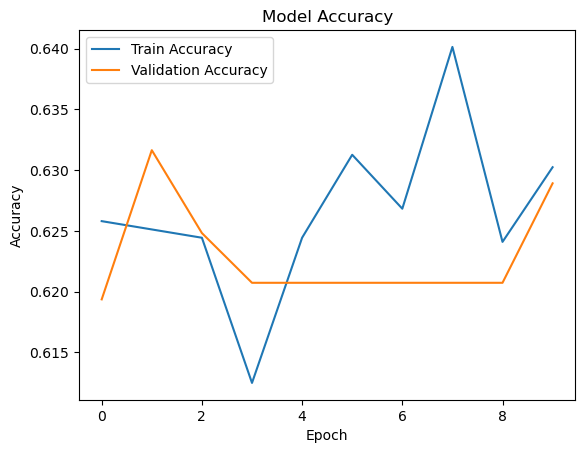

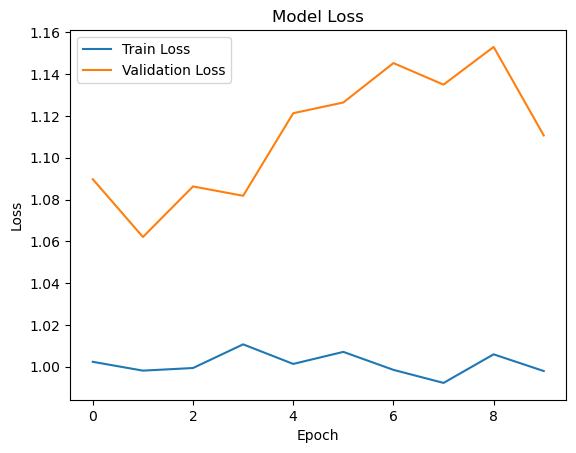

In [184]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [185]:
val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6282 - loss: 1.0841
Validation Loss: 1.1106773614883423, Validation Accuracy: 0.6289222240447998


In [186]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load a test image (adjust path accordingly)
image_path = r"C:\_____PYHTON\python\retinopathy_diabetes\gaussian_filtered_images\gaussian_filtered_images\Moderate\000c1434d8d7.png" # Replace with your test image path
image = load_img(image_path, target_size=(224, 224))  # Resize to input size
image_array = img_to_array(image) / 255.0  # Normalize pixel values
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension


In [187]:
prediction = model.predict(image_array)
print("Prediction (probabilities):", prediction)

# Get the class with the highest probability
predicted_class = np.argmax(prediction, axis=1)
print(f"Predicted Class: {predicted_class[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction (probabilities): [[0.17111191 0.16761972 0.42797527 0.08781973 0.14547332]]
Predicted Class: 2


In [188]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get true labels and predictions
y_true = valid_generator.classes  # True labels from the validation generator
y_pred = model.predict(valid_generator)  # Predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=valid_generator.class_indices.keys()))


23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
Confusion Matrix:
[[180   0 162   0   0]
 [ 44   0  50   0   0]
 [112   0  89   0   0]
 [ 28   0  21   0   0]
 [ 20   0  27   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.53      0.50       342
           1       0.00      0.00      0.00        94
           2       0.26      0.44      0.32       201
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        47

    accuracy                           0.37       733
   macro avg       0.14      0.19      0.16       733
weighted avg       0.29      0.37      0.32       733



C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


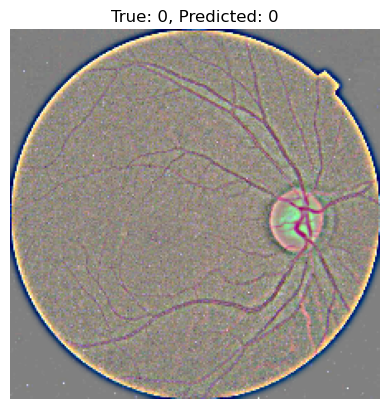

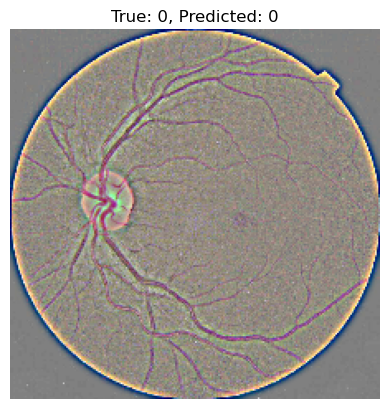

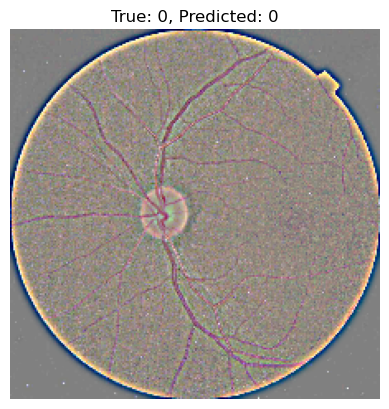

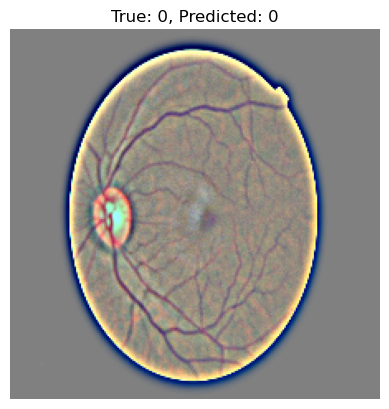

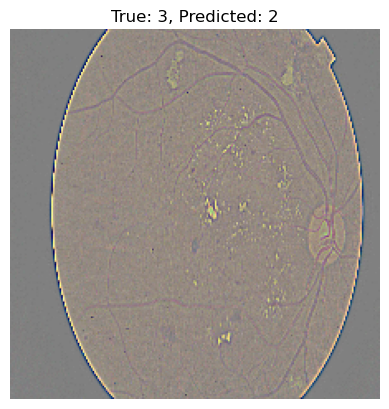

In [189]:
import matplotlib.pyplot as plt

# Get a batch of validation images and labels
images, labels = next(valid_generator)
predictions = model.predict(images)

# Plot the first 5 images
for i in range(5):
    plt.imshow(images[i])
    plt.title(f"True: {np.argmax(labels[i])}, Predicted: {np.argmax(predictions[i])}")
    plt.axis('off')
    plt.show()



In [190]:
# Specify the full path where the model should be saved
save_path = r"C:\_____PYHTON\python\retinopathy_diabetes\diabetic_retinopathy_model.h5"

# Save the model
model.save(save_path)
print(f"Model saved successfully at {save_path}!")


Model saved successfully at C:\_____PYHTON\python\retinopathy_diabetes\diabetic_retinopathy_model.h5!
